In [46]:
!git clone https://github.com/kairosfuture/dcipher-nlp-challenge.git
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

fatal: destination path 'dcipher-nlp-challenge' already exists and is not an empty directory.
Looking in indexes: https://test.pypi.org/simple/


In [64]:
import json
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import spacy
from torchtext.data import Field, TabularDataset, BucketIterator
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
def normalise_text(text):

    text = text.str.lower()
    text = text.str.replace(r"\#", "")
    text = text.str.replace(r"http\S+", "URL")
    text = text.str.replace(r"@", "")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")

    return text

In [50]:
file = '/content/dcipher-nlp-challenge/data/wos2class.json'
with open(file) as df:
    dict_train = json.load(df)
df = pd.DataFrame.from_dict(dict_train)

df.isna().sum()
df.drop(df[df['Abstract'].str.len() < 10].index, inplace=True)
df['title_abstract'] = df['Title'] + ". " + df['Abstract']
df['Label'] = (df['Label'] == 'Material Science').astype('int')
df["title_abstract"] = normalise_text(df["title_abstract"])

In [51]:
train, test, y_train, y_test = train_test_split(df["title_abstract"],
                                                df["Label"],
                                                test_size=0.2,
                                                random_state=42,
                                                stratify=df["Label"])

train, val, y_train, y_val = train_test_split(train,
                                              y_train,
                                              test_size=0.2,
                                              random_state=42,
                                              stratify=y_train)

df_train = pd.concat([train, y_train], ignore_index=True, sort=False, axis=1)
df_val = pd.concat([val, y_val], ignore_index=True, sort=False, axis=1)
df_test = pd.concat([test, y_test], ignore_index=True, sort=False, axis=1)

df_train.to_csv('train.csv', index=False)
df_val.to_csv('valid.csv', index=False)
df_test.to_csv('test.csv', index=False)
df_train.to_json('wos2class.train.json')
df_val.to_json('wos2class.valid.json')
df_test.to_json('wos2class.test.json')

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True  
seed = 17
torch.manual_seed(seed)

In [53]:
label_field = Field(sequential=False,
                    use_vocab=False,
                    dtype=torch.float,
                    batch_first=True)

text_field = Field(sequential=True,
                   tokenize='spacy',
                   batch_first=True,
                   include_lengths=True,
                   lower=True)

fields = {'1': ('label', label_field), '0': ('title_abstract', text_field)}

train, valid, test = TabularDataset.splits(path='./',
                                           train='train.csv',
                                           validation='valid.csv',
                                           test='test.csv',
                                           format='CSV', fields=fields)

text_field.build_vocab(train, min_freq=8, vectors="glove.6B.100d")

In [54]:
train_iter = BucketIterator(train,
                            batch_size=32,
                            sort_key=lambda x: len(x.title_abstract),
                            sort_within_batch=True,
                            device=device)

valid_iter = BucketIterator(valid,
                            batch_size=32,
                            sort_key=lambda x: len(x.title_abstract),
                            sort_within_batch=True,
                            device=device)

test_iter = BucketIterator(test,
                           batch_size=32,
                           sort_key=lambda x: len(x.title_abstract),
                           sort_within_batch=True,
                           device=device)

In [56]:
class lstm(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 num_layers, bidirection, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)

        self.embeddings = nn.Embedding(vocab_size,
                                       embedding_dim,
                                       padding_idx=0)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            batch_first=True,
                            num_layers=num_layers,
                            bidirectional=bidirection)

        self.linear = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, length):
        x = self.embeddings(input)
        x = self.dropout(x)

        x_pack = nn.utils.rnn.pack_padded_sequence(x,
                                      length.cpu(),
                                      batch_first=True,
                                      enforce_sorted=False)

        out_pack, (ht, ct) = self.lstm(x_pack)
        ht = torch.cat((ht[-2, :, :], ht[-1, :, :]), dim=1)
        dense_outputs = self.linear(ht)
        outputs = self.softmax(dense_outputs)
        return outputs

In [57]:
size_of_vocab = len(text_field.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 2
num_layers = 2
bidirection = True
dropout = 0.2

model = lstm(size_of_vocab,
             embedding_dim,
             num_hidden_nodes,
             num_output_nodes,
             num_layers,
             bidirection,
             dropout)

In [42]:
pretrained_embeddings = text_field.vocab.vectors
model.embeddings.weight.data.copy_(pretrained_embeddings)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion  = nn.NLLLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        title_abstract, title_abstract_lengths = batch.title_abstract
        labels = batch.label
        preds = model(title_abstract, title_abstract_lengths)
        loss = criterion(preds, labels.long())

        preds = torch.argmax(preds, axis=1)
        correct = (preds == labels).float()
        acc = correct.sum() / len(correct)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():

        for batch in iterator:

            title_abstract, title_abstract_lengths = batch.title_abstract
            labels = batch.label
            preds = model(title_abstract, title_abstract_lengths)
            loss = criterion(preds, labels.long())

            preds = torch.argmax(preds, axis=1)
            correct = (preds == labels).float()
            acc = correct.sum() / len(correct)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

N_EPOCHS = 25
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_iter, optimizer, criterion)

    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/weights_dcipher/lstm_weights.pt')

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

100%|█████████▉| 398428/400000 [00:30<00:00, 25583.45it/s]

	Train Loss: 0.687 | Train Acc: 54.22%
	 Val. Loss: 0.673 |  Val. Acc: 63.04%
	Train Loss: 0.654 | Train Acc: 61.79%
	 Val. Loss: 0.623 |  Val. Acc: 62.55%
	Train Loss: 0.622 | Train Acc: 62.90%
	 Val. Loss: 0.604 |  Val. Acc: 63.70%
	Train Loss: 0.596 | Train Acc: 65.03%
	 Val. Loss: 0.576 |  Val. Acc: 66.81%
	Train Loss: 0.570 | Train Acc: 68.04%
	 Val. Loss: 0.559 |  Val. Acc: 68.27%
	Train Loss: 0.555 | Train Acc: 69.17%
	 Val. Loss: 0.552 |  Val. Acc: 68.51%
	Train Loss: 0.548 | Train Acc: 69.88%
	 Val. Loss: 0.550 |  Val. Acc: 68.76%
	Train Loss: 0.538 | Train Acc: 70.96%
	 Val. Loss: 0.548 |  Val. Acc: 68.18%
	Train Loss: 0.528 | Train Acc: 71.56%
	 Val. Loss: 0.551 |  Val. Acc: 69.07%
	Train Loss: 0.525 | Train Acc: 72.51%
	 Val. Loss: 0.546 |  Val. Acc: 69.08%
	Train Loss: 0.517 | Train Acc: 72.82%
	 Val. Loss: 0.549 |  Val. Acc: 69.65%
	Train Loss: 0.510 | Train Acc: 73.34%
	 Val. Loss: 0.544 |  Val. Acc: 68.58%
	Train Loss: 0.499 | Train Acc: 74.43%
	 Val. Loss: 0.545 |  Val

In [58]:
with torch.no_grad():
    torch.cuda.empty_cache()
path = '/content/drive/MyDrive/weights_dcipher/lstm_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [66]:
model = model.to(device)

preds = []
probas_0 = []
probas_1 = []

for i, batch in enumerate(test_iter):

    title_abstract, title_abstract_lengths = batch.title_abstract

    with torch.no_grad():
        pred = model(title_abstract, title_abstract_lengths).float()
        probas_0.extend(pred[: , 0:1].squeeze().detach().cpu().numpy())
        probas_1.extend(pred[: , 1:2].squeeze().detach().cpu().numpy())
        pred = torch.argmax(pred, axis=1)
        pred = pred.squeeze().detach().cpu().numpy()
        preds.extend(pred)

preds = np.asarray(preds)
print(classification_report(y_test, preds))
pd.crosstab(y_test, preds)

              precision    recall  f1-score   support

           0       0.51      0.51      0.51       740
           1       0.52      0.51      0.51       759

    accuracy                           0.51      1499
   macro avg       0.51      0.51      0.51      1499
weighted avg       0.51      0.51      0.51      1499



col_0,0,1
Label,,
0,379,361
1,371,388


Class 1: ROC AUC = 0.491
F1 Score = 0.490
Accuracy = 0.488


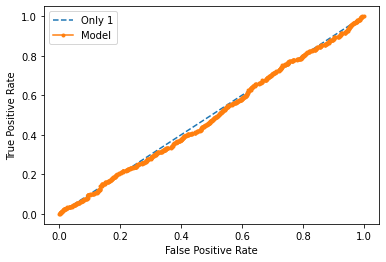

In [65]:
auc_1 = roc_auc_score(y_test, probas_1)

print('Class 1: ROC AUC = %.3f' % (auc_1))

f1 = f1_score(y_test, preds)
print('F1 Score = %.3f' % (f1))

acc = accuracy_score(y_test, preds)
print('Accuracy = %.3f' % (acc))

ns_1 = [1 for _ in range(len(y_test))]

fpr_0, tpr_0, _ = roc_curve(y_test, probas_0)
fpr_1, tpr_1, _ = roc_curve(y_test, probas_1)
fpr_ns_1, tpr_ns_1, _ =  roc_curve(y_test, ns_1)

pyplot.plot(fpr_ns_1, tpr_ns_1, linestyle='--', label='Only 1')
pyplot.plot(fpr_1, tpr_1, marker='.', label='Model')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()